In [1]:
import pandas as pd
import numpy as np
from preprocessing import get_preprocessor, get_preprocessor_poly
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns
set_config(transform_output="pandas")

import the data from the cloud

In [2]:
df = pd.read_csv("https://storage.googleapis.com/second-try-ml/air-pollution/Train.csv")
df.head(2)

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.0,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.6,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652


define features and targets and split data into train and test

In [3]:
RSEED = 42
X = df.drop("target", axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, shuffle=True, random_state=RSEED)
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head(2)

,Place_ID X Date,Date,Place_ID,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,...,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle,target
19308,KYNZWCA X 2020-03-10,2020-03-10,KYNZWCA,4.0,61.0,1726.84,61,16.518541,63.600002,0.006580,...,-39.126728,41.704754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0
7260,7DRFQCK X 2020-03-08,2020-03-08,7DRFQCK,3.0,55.0,2115.89,168,3.186504,57.642859,0.001815,...,66.413640,69.282032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0


load preprocessor 1

In [4]:
preproc = get_preprocessor()

define function for printing model performance values

In [6]:
def print_scores(y_train, y_test, y_pred_train, y_pred):
    print("Train RMSE: ", mean_squared_error(y_train, y_pred_train, squared=False))
    print("Train R^2: ", r2_score(y_train, y_pred_train))
    print("Test RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
    print("Test R^2: ", r2_score(y_test, y_pred))

split train data for testing a stacked model

In [7]:
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, test_size=0.4, shuffle=True, random_state=RSEED)

import preprocessor for linear model (with polynomial expansion)

In [8]:
preproc_poly = get_preprocessor_poly()

Train RMSE:  32.067895160464666
Train R^2:  0.5328587049133635
Test RMSE:  35.27355923220966
Test R^2:  0.44102233323214013


define and asses ride regressor model

In [ ]:
rid = Pipeline([
    ("preproc", preproc_poly),
    ("ridge", RidgeCV(cv=3)),
    ])

rid.fit(X_train_1, y_train_1)

rid_pred = rid.predict(X_train_2)
rid_pred_train = rid.predict(X_train_1)

print_scores(y_train_1, y_train_2, rid_pred_train, rid_pred)

define and asses k nearest neighbors regressor model

In [9]:
knn = Pipeline([
    ("preproc", preproc),
    ("knn", KNeighborsRegressor(n_neighbors=10, weights="distance")),
    ])

knn.fit(X_train_1, y_train_1)

knn_pred = knn.predict(X_train_2)
knn_pred_train = rid.predict(X_train_1)

print_scores(y_train_1, y_train_2, knn_pred_train, knn_pred)

Train RMSE:  32.067895160464666
Train R^2:  0.5328587049133635
Test RMSE:  34.14845771519231
Test R^2:  0.47611245105784006


define and asses random forest regressor model

In [10]:
randF = Pipeline([
    ("preproc", preproc),
    ("randF", RandomForestRegressor(n_estimators=200, max_depth=10, random_state=RSEED, n_jobs=-1)),
    ])

randF.fit(X_train_1, y_train_1)
randF_pred = randF.predict(X_train_2)
randF_pred_train = rid.predict(X_train_1)

print_scores(y_train_1, y_train_2, randF_pred_train, randF_pred)

Train RMSE:  32.067895160464666
Train R^2:  0.5328587049133635
Test RMSE:  34.596993905582686
Test R^2:  0.4622596579376611


define and asses random forest regressor model as a final estimator in a stacked approach

In [11]:
df_train_final = pd.concat([pd.DataFrame(rid_pred), pd.DataFrame(knn_pred), pd.DataFrame(randF_pred)], axis=1)
finalForest = RandomForestRegressor(n_estimators=20, max_depth=3, random_state=RSEED, n_jobs=-1)
finalForest.fit(df_train_final, y_train_2)

final_pred_train = finalForest.predict(df_train_final)

rid_pred_test = rid.predict(X_test)
knn_pred_test = knn.predict(X_test)
randF_pred_test = randF.predict(X_test)

comb_pred = pd.concat([
            pd.DataFrame(rid_pred_test), 
            pd.DataFrame(knn_pred_test),
            pd.DataFrame(randF_pred_test),
        ], axis=1)

final_pred = finalForest.predict(comb_pred)

print_scores(y_train_2, y_test, final_pred_train, final_pred)

Train RMSE:  32.43769052879669
Train R^2:  0.5272889643837524
Test RMSE:  32.17202195545843
Test R^2:  0.5207562300922104


define (sklearn) stacking regressor

In [12]:
estimators = [("rid", rid), ("knn", knn), ("randF", randF)]

In [13]:
sr = StackingRegressor(estimators=estimators, final_estimator=finalForest, cv=5, n_jobs=-1)

In [14]:
sr.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('rid',
                               Pipeline(steps=[('preproc',
                                                Pipeline(steps=[('ordinal_date',
                                                                 <preprocessing.ordinalDateTransformer object at 0x000001DB745469A0>),
                                                                ('wind_transform',
                                                                 <preprocessing.windTransformer object at 0x000001DB74546340>),
                                                                ('drop_cols',
                                                                 <preprocessing.columnDropTransformer object at 0x000001DB74546CD0>),
                                                                ('impute',
                                                                 SimpleImputer(stra...
                                                                 <preprocessing.columnDropTransformer object at 0x000001DB74546310>),
                                                                ('impute',
                                                                 SimpleImputer(strategy='median')),
                                                                ('logit',
                                                                 <preprocessing.logTransformer object at 0x000001DB74546820>),
                                                                ('scaling',
                                                                 StandardScaler())])),
                                               ('randF',
                                                RandomForestRegressor(max_depth=10,
                                                                      n_estimators=200,
                                                                      n_jobs=-1,
                                                                      random_state=42))]))],
                  final_estimator=RandomForestRegressor(max_depth=3,
                                                        n_estimators=20,
                                                        n_jobs=-1,
                                                        random_state=42),
                  n_jobs=-1)

asses performance of stacked regressor

In [15]:
y_pred_train = sr.predict(X_train)
y_pred = sr.predict(X_test)

print("Train RMSE: ", mean_squared_error(y_train, y_pred_train, squared=False))
print("Train R^2: ", r2_score(y_train, y_pred_train))
print("Test RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2: ", r2_score(y_test, y_pred)) # 31.2285 with n=100, cv=3, depth=4

Train RMSE:  17.56632812088446
Train R^2:  0.8604582911941985
Test RMSE:  31.407958217872654
Test R^2:  0.5432493521400481


plot prediction vs test data

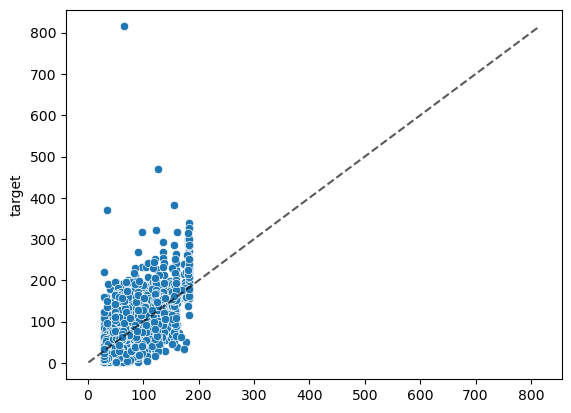

In [16]:
fig, ax = plt.subplots(1,1)
sns.scatterplot(x=y_pred, y=y_test, ax=ax)
mini = min([min(y_pred), min(y_test)])
maxi = max([max(y_pred), max(y_test)])
ax.plot(np.linspace(mini, maxi, 2), np.linspace(mini, maxi, 2), 'k--', alpha=0.65)

In [17]:
df_res = pd.DataFrame({"y_pred": y_pred, "y_test": y_test})
df_res

,y_pred,y_test
24141,62.660871,79.0
26865,126.372358,129.0
22772,44.530328,72.0
25624,85.826754,34.0
21690,71.038106,61.0
...,...,...
7201,28.661779,17.0
19407,28.661779,25.0
19609,61.769886,63.0
26644,28.661779,34.0
